# Spatial features

Find largest distance in current dataset for normalization!

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [2]:
from pathlib import Path
import pickle
import sys

import pandas as pd

from kinsim_structure.auxiliary import KlifsMoleculeLoader, PdbChainLoader
from kinsim_structure.encoding import Fingerprint, PhysicoChemicalFeatures, SpatialFeatures
from kinsim_structure.encoding import PharmacophoreSizeFeatures, SideChainOrientationFeature, ExposureFeature

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [4]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results'

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load metadata

In [5]:
klifs_metadata = pd.read_csv(metadata_path)

In [12]:
a=klifs_metadata[klifs_metadata.qualityscore < 5]

In [13]:
a.shape

(35, 23)

In [14]:
a

,Unnamed: 0,index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,...,dfg,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp
778,782,3059,CDK2,CDK,CMGC,5d1j,A,-,Human,"N-(5-{[(5-tert-butyl-1,3-oxazol-2-yl)methyl]su...",...,in,out,0.772,2.022,4.8,EKIGE__YGVVYKVALKK___IREISLLKELNPNIVKLLDVYLVFE...,1.80,8,23,0000000000000010000001000000100000000000000000...
800,805,6883,CDK2,CDK,CMGC,6ath,A,B,Human,-,...,in,in,0.774,1.934,4.4,_________VVYKVALKKITAIREISLLKELNPNIVKLLDVYLVFE...,1.82,9,0,NaN
829,834,5898,CDK4,CDK,CMGC,5fwk,K,-,Human,-,...,in,na,1.171,2.516,2.4,_________________________________________TLVFE...,3.90,41,0,NaN
830,835,5756,CDK4,CDK,CMGC,5fwl,K,-,Human,-,...,in,out,1.170,9.766,4.0,AEIGVGAYGTVYKVALKSVSTVREVALLRRLEPNVVRLMDVTLVFE...,9.00,0,0,NaN
831,836,5755,CDK4,CDK,CMGC,5fwm,K,-,Human,-,...,in,out,1.166,9.834,4.0,AEIGVGAYGTVYKVALKSVSTVREVALLRRLEPNVVRLMDVTLVFE...,8.00,0,0,NaN
832,837,7043,CDK4,CDK,CMGC,5fwp,K,-,Human,-,...,in,na,1.169,2.513,2.4,_________________________________________TLVFE...,7.20,41,0,NaN
1291,1298,1399,CLK3,CLK,CMGC,2exe,A,B,Human,-,...,in,in,0.780,1.986,4.0,____________________ARLEINVLKKIKFLCVLMSD___AFE...,2.35,23,40,NaN
2172,2181,5993,ITK,Tec,TK,3mj1,A,-,Human,7-[(4-methylpiperazin-1-yl)methyl]-4-[(3-methy...,...,in,out,0.781,1.962,4.8,QEIGSG__GLVHLVAIKTI___EEAEVMMKLSPKLVQLYGVCLVFE...,1.72,8,0,0000000000000010000001000000100000000000000000...
2192,2201,47,ITK,Tec,TK,4mf0,A,-,Human,"(1S,2S)-2-{4-[(dimethylamino)methyl]phenyl}-N-...",...,in,out,0.828,4.841,2.8,QEIGSG___LVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,2.67,3,0,0000000000000000000000000000000000000000000000...
2195,2204,13,ITK,Tec,TK,4ppa,B,-,Human,N-[1-(3-cyanobenzyl)-1H-pyrazol-4-yl]-6-(1H-py...,...,in,out,0.836,5.689,3.2,QEIGSGQFGLVHLVAIKTIDFIEEAEVMMKLSPKLVQLYGVCLVFE...,2.67,2,0,0000000000000000000000000000000000000000000000...


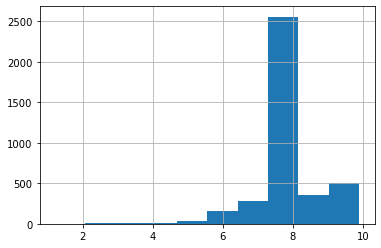

In [10]:
klifs_metadata.qualityscore.hist()

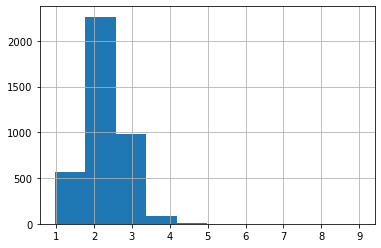

In [15]:
klifs_metadata.resolution.hist()

In [16]:
import matplotlib.pyplot as plt

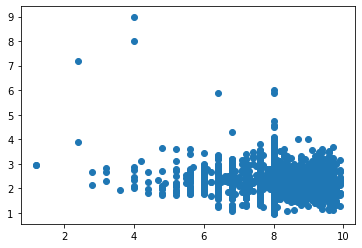

In [17]:
plt.scatter(klifs_metadata.qualityscore, klifs_metadata.resolution)

In [6]:
klifs_metadata_entry = klifs_metadata.iloc[250]

## Maximum distance per molecule and per reference point

In [19]:
space = SpatialFeatures()

max_per_molecule = []

for index, row in klifs_metadata.iterrows():
    
    ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
    space.from_molecule(ml.molecule)
    
    max_per_molecule.append(space.features.max(axis=0))

In [22]:
max_distances = pd.DataFrame(max_per_molecule)

In [25]:
max_distances

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
0,22.65,25.62,27.98,26.89
1,22.85,25.31,28.08,26.56
2,23.63,24.71,28.69,26.68
3,20.98,23.72,26.44,25.75
4,21.84,22.54,28.11,23.29
5,21.43,23.33,26.33,24.14
6,20.81,23.74,25.95,25.08
7,22.41,23.78,27.93,NaN
8,21.21,23.69,26.07,24.32
9,21.07,23.70,26.91,25.79


### Save data

In [27]:
with open(path_to_results / 'distances_max.p', 'wb') as f:
    pickle.dump(max_distances, f)

### Load and plot data

In [51]:
with open(path_to_results / 'distances_max.p', 'rb') as f:
    max_distances = pickle.load(f)

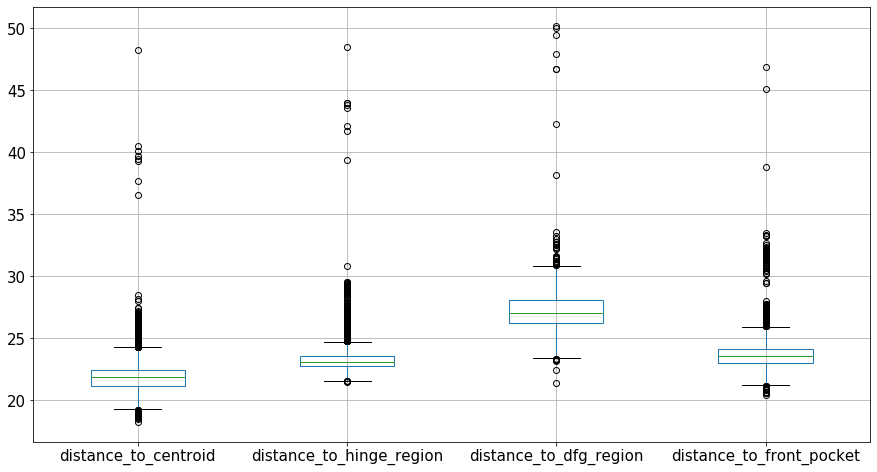

In [52]:
boxplot = max_distances.boxplot(figsize=(15,8), fontsize=15)

In [40]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_max_boxplot.png', dpi=300)

### Look at some of those >40 distances

In [45]:
max_distances[max_distances.distance_to_centroid > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [46]:
max_distances[max_distances.distance_to_hinge_region > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [47]:
max_distances[max_distances.distance_to_dfg_region > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2192,39.30,41.74,46.74,31.05
2195,40.10,43.96,50.04,31.97
2196,39.71,43.58,49.45,31.72
2197,36.58,39.39,46.71,27.35
2199,40.49,43.79,50.13,32.07
2833,48.20,48.51,47.91,38.83


In [48]:
max_distances[max_distances.distance_to_front_pocket > 35]

,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket
830,37.66,42.10,38.16,45.08
831,39.42,44.00,42.28,46.86
2833,48.20,48.51,47.91,38.83


In [50]:
klifs_metadata.index

RangeIndex(start=0, stop=3917, step=1)

In [8]:
klifs_metadata.iloc[2833]

Unnamed: 0                                                                2845
index                                                                     6942
kinase                                                                     PBK
family                                                                    TOPK
groups                                                                   Other
pdb_id                                                                    5j0a
chain                                                                        A
alternate_model                                                              -
species                                                                  Human
ligand_orthosteric_name                                                      -
ligand_orthosteric_pdb_id                                                    -
ligand_allosteric_name                            4&apos;-HYDROXYCINNAMIC ACID
ligand_allosteric_pdb_id                            

## Distances per molecule and per reference point

In [53]:
space = SpatialFeatures()

dist_per_molecule = []

for index, row in klifs_metadata.iterrows():
    
    ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
    space.from_molecule(ml.molecule)
    
    dist_per_molecule.append(space.features)

In [57]:
all_distances = pd.concat(dist_per_molecule)

### Save data

In [58]:
with open(path_to_results / 'distances_all.p', 'wb') as f:
    pickle.dump(all_distances, f)

### Load and plot data

In [59]:
with open(path_to_results / 'distances_all.p', 'rb') as f:
    all_distances = pickle.load(f)

In [60]:
all_distances.shape

(328182, 4)

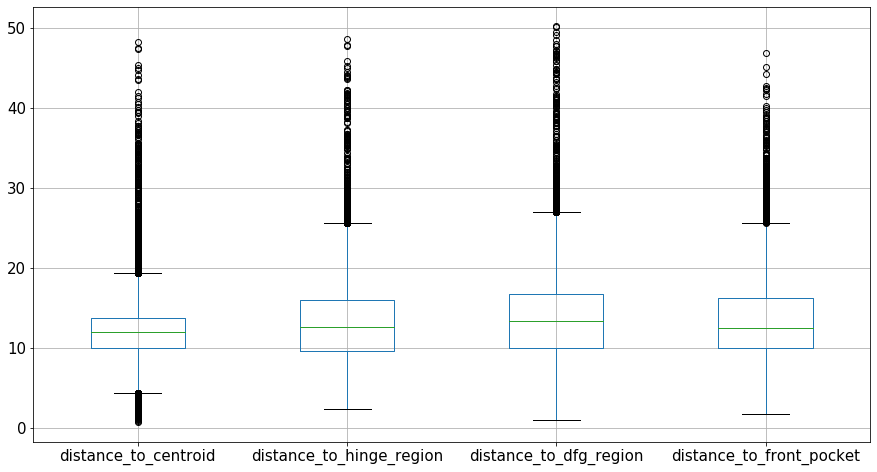

In [61]:
boxplot = all_distances.boxplot(figsize=(15,8), fontsize=15)

In [62]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_all_boxplot.png', dpi=300)